### Importation des bibliothèques

In [2]:
import os

import numpy as np

import matplotlib.pyplot as plt

from skimage import io, color, data, transform
from sklearn.datasets import fetch_lfw_people
from skimage.feature import hog

from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.image import PatchExtractor

from itertools import chain  

import joblib

from TIPEutils import sliding_window

### Chargement des données d'entraînement

In [3]:
faces = fetch_lfw_people()             # Visages du dataset LFW
positive_patches = faces.images        # Ces images seront nos "zones positives"

# Pour les "zones négatives", on prend des images de thémes variés qui ne contennient pas de visage
imgs_to_use = ['camera', 'text', 'coins', 'moon',
               'page', 'clock', 'immunohistochemistry',
               'chelsea', 'coffee', 'hubble_deep_field']
images = [color.rgb2gray(getattr(data, name)())
          for name in imgs_to_use]

def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches

negatives_patches = np.vstack([extract_patches(im, 1000, scale)
                              for im in images for scale in [0.5, 1.0, 2.0]])

X_train = np.array([hog(img)
                    for img in chain(positive_patches,
                                     negatives_patches)])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1         # les positifs auront le label 1, les négatifs 0

<ipython-input-3-5ea92dd4faae>:9: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  images = [color.rgb2gray(getattr(data, name)())


In [4]:
grid = GridSearchCV(LinearSVC(), {'C': [1.0, 2.0, 4.0, 8.0]})
grid.fit(X_train, y_train)
grid.best_score_

/Users/julesdupont/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/julesdupont/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/julesdupont/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/julesdupont/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/julesdupont/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.p

0.9885503914410378

In [8]:
grid.best_params_

{'C': 1.0}

In [9]:
model = grid.best_estimator_
# model.fit(X_train, y_train)    pas besoin car déjà refit ??

LinearSVC()

### Test

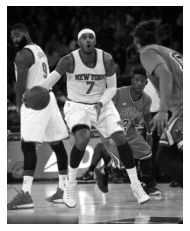

In [6]:
test_image = io.imread('img/basket.jpeg')  
test_image = color.rgb2gray(test_image)
test_image = transform.rescale(test_image, 0.5)
#test_image = test_image[:160, 40:180]

plt.imshow(test_image, cmap='gray')
plt.axis('off');

In [7]:
def sliding_window_old(img, patch_size=positive_patches[0].shape,
                   istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch
            
indices, patches = zip(*sliding_window_old(test_image))
patches_hog = np.array([hog(patch) for patch in patches])
patches_hog.shape

NameError: name 'positive_patches' is not defined

In [63]:
indices, patches = sliding_window.main(test_image, positive_patches[0].shape[0], positive_patches[0].shape[1])
patches_hog = np.array([hog(patch) for patch in patches])
patches_hog.shape

(53, 1215)

In [65]:
labels = model.predict(patches_hog)
labels.sum()

153.0

### Affichage des résultats

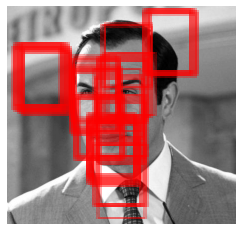

In [66]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

Ni, Nj = positive_patches[0].shape
indices = np.array(indices)

for i, j in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=0.3, lw=2, facecolor='none'))

### Export du modèle

In [28]:
filename = 'model_test.txt'
saved_filename = joblib.dump(model, filename, compress=9)
print(saved_filename)
print(filename)
if saved_filename == filename:
    print("Model saved successfully")
else:
    print("Error saving model")

['model_test.txt']
model_test.txt
Error saving model


In [34]:
positive_patches[0].shape

(62, 47)

## À améliorer
- Les jeux d'entraînement ne sont pas assez complets
- Faire du hard negative mining; on prend un set de nouvelles images, on trouve tous les patches qui représentent des faux positifs et on retrain notre modèle en lui passant ses erreurs comme négatifs
- Nos patches ont tous la même scale
- MeanShift Clustering